Diabetes Prediction using BRFSS 2015 Dataset with ML & IBM Granite Insights

In [ ]:
import getpass
token = getpass.getpass('Masukkan GitHub Token: ')

Masukkan GitHub Token: ··········


In [ ]:
!git config --global user.name "Jakij4ki"
!git config --global user.email "dzakyrezandi1714@gmail.com"

##Install package

In [ ]:
!pip install requests==2.32.4

  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
Using cached requests-2.32.4-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.5
    Uninstalling requests-2.32.5:
      Successfully uninstalled requests-2.32.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.29 requires requests<3,>=2.32.5, but you have requests 2.32.4 which is incompatible.


In [ ]:
!pip install langchain_community
!pip install replicate

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


##Import library

In [50]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [15]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
  model=model,
  replicate_api_token=api_token,
)

In [16]:
# Model parameters
parameters = {
    "top_k": 5,
    "top_p": 1.0,
    "max_tokens": 300,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (300 tokens)",
    "stopping_sequence": None
}

In [17]:
def granite_ask(prompt):
    response = output.invoke(prompt, parameters=parameters)
    print("Granite Model Response:\n")
    print(response)
    return response

In [19]:
df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')

# Tampilkan jumlah baris dan kolom
print("Shape dataset:", df.shape)  # format: (baris, kolom)
print("Jumlah baris:", df.shape[0])
print("Jumlah kolom:", df.shape[1])


Shape dataset: (253680, 22)
Jumlah baris: 253680
Jumlah kolom: 22


#Data Understanding

In [20]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [24]:
df['Diabetes_012'].value_counts()

,count
Diabetes_012,
0.0,213703
2.0,35346
1.0,4631


In [23]:
df['Diabetes_012'].value_counts(normalize=True) * 100

,proportion
Diabetes_012,
0.0,84.241170
2.0,13.933302
1.0,1.825528


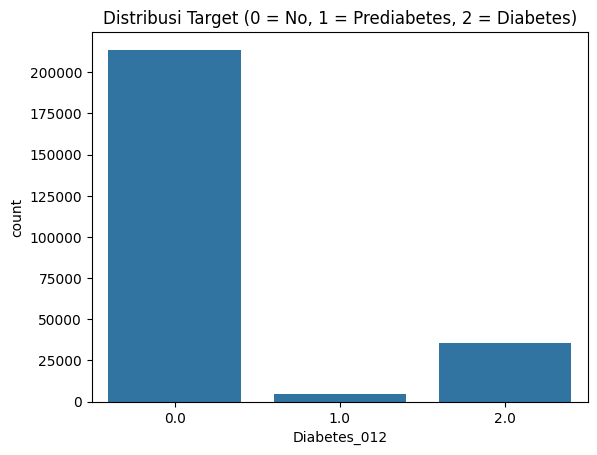

In [22]:
sns.countplot(x="Diabetes_012", data=df)
plt.title("Distribusi Target (0 = No, 1 = Prediabetes, 2 = Diabetes)")
plt.show()



In [21]:
prompt_data_understanding = """
Kamu adalah asisten data scientist.
Saya punya dataset diabetes health indicators (BRFSS 2015).
Tolong buatkan penjelasan lengkap tentang data understanding:
- Deskripsi tiap kolom (feature dan target).
- Distribusi awal data (contoh apa yang perlu dicek).
- Potensi insight awal.
Tuliskan seperti untuk laporan capstone.
"""
granite_ask(prompt_data_understanding)

Granite Model Response:

**Data Understanding for Diabetes Health Indicators (BRFSS 2015)**

**1. Deskripsi Kolom (Feature dan Target):**

The dataset, derived from the Behavioral Risk Factor Surveillance System (BRFSS) in 2015, comprises various health indicators relevant to diabetes. Below is a detailed description of each feature and target variable:

- **Age (Age):** Age of the respondent in years. This feature is crucial as diabetes prevalence varies with age.

- **Sex (Sex):** Binary variable indicating the respondent's sex (1 for male, 2 for female). Diabetes prevalence and management can differ between genders.

- **Race (Race):** Categorical variable representing the respondent's race/ethnicity (1 for White, 2 for Black, 3 for Hispanic, 4 for Other, 5 for Multiracial). Race is a known risk factor for diabetes.

- **Education (Education):** Categorical variable indicating the highest level of education achieved (1 for less than HS, 2 for HS diploma or equivalent, 3 for some col

"**Data Understanding for Diabetes Health Indicators (BRFSS 2015)**\n\n**1. Deskripsi Kolom (Feature dan Target):**\n\nThe dataset, derived from the Behavioral Risk Factor Surveillance System (BRFSS) in 2015, comprises various health indicators relevant to diabetes. Below is a detailed description of each feature and target variable:\n\n- **Age (Age):** Age of the respondent in years. This feature is crucial as diabetes prevalence varies with age.\n\n- **Sex (Sex):** Binary variable indicating the respondent's sex (1 for male, 2 for female). Diabetes prevalence and management can differ between genders.\n\n- **Race (Race):** Categorical variable representing the respondent's race/ethnicity (1 for White, 2 for Black, 3 for Hispanic, 4 for Other, 5 for Multiracial). Race is a known risk factor for diabetes.\n\n- **Education (Education):** Categorical variable indicating the highest level of education achieved (1 for less than HS, 2 for HS diploma or equivalent, 3 for some college, 4 for 

#Data Cleaning

In [29]:
print("Jumlah missing values tiap kolom:\n")
print(df.isnull().sum())

Jumlah missing values tiap kolom:

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


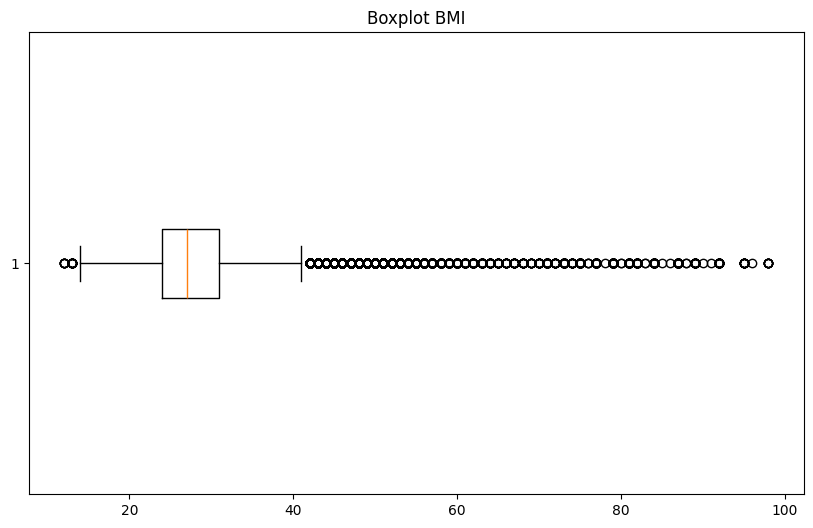

In [30]:
plt.figure(figsize=(10,6))
plt.boxplot(df['BMI'], vert=False)
plt.title("Boxplot BMI")
plt.show()

In [31]:
z_scores = stats.zscore(df['BMI'])
abs_z_scores = np.abs(z_scores)

In [32]:
outliers = np.where(abs_z_scores > 3)
print(f"Jumlah outlier di kolom BMI: {len(outliers[0])}")

Jumlah outlier di kolom BMI: 2963


In [27]:
for col in df.columns:
    print(f"{col:<15} | unique: {df[col].nunique():<5} | contoh: {df[col].unique()[:10]}")

Diabetes_012    | unique: 3     | contoh: [0. 2. 1.]
HighBP          | unique: 2     | contoh: [1. 0.]
HighChol        | unique: 2     | contoh: [1. 0.]
CholCheck       | unique: 2     | contoh: [1. 0.]
BMI             | unique: 84    | contoh: [40. 25. 28. 27. 24. 30. 34. 26. 33. 21.]
Smoker          | unique: 2     | contoh: [1. 0.]
Stroke          | unique: 2     | contoh: [0. 1.]
HeartDiseaseorAttack | unique: 2     | contoh: [0. 1.]
PhysActivity    | unique: 2     | contoh: [0. 1.]
Fruits          | unique: 2     | contoh: [0. 1.]
Veggies         | unique: 2     | contoh: [1. 0.]
HvyAlcoholConsump | unique: 2     | contoh: [0. 1.]
AnyHealthcare   | unique: 2     | contoh: [1. 0.]
NoDocbcCost     | unique: 2     | contoh: [0. 1.]
GenHlth         | unique: 5     | contoh: [5. 3. 2. 4. 1.]
MentHlth        | unique: 31    | contoh: [18.  0. 30.  3.  5. 15. 10.  6. 20.  2.]
PhysHlth        | unique: 31    | contoh: [15.  0. 30.  2. 14. 28.  7. 20.  3. 10.]
DiffWalk        | unique: 2  

In [26]:
prompt_data_cleaning = """
Berdasarkan dataset diabetes health indicators, buatkan langkah-langkah
data cleaning yang detail, mencakup:
- Handling missing values
- Deteksi outlier
- Encoding variabel kategorikal (jika ada)
- Normalisasi/standarisasi jika diperlukan
- Data imbalance (karena target 0,1,2 tidak seimbang)
Tuliskan dalam bentuk langkah + contoh kode python (pandas/sklearn).
"""
granite_ask(prompt_data_cleaning)

Granite Model Response:

Langkah-langkah data cleaning untuk dataset diabetes health indicators adalah sebagai berikut:

1. **Handling Missing Values**

   - Identifikasi nilai missing dengan `isnull().sum()`
   - Pilihan akomodasi:
     - Menghapus baris atau kolom yang memiliki nilai missing (misal, dengan `dropna()`)
     - Imputation nilai missing (misal, dengan mean, median, mode, atau metode kriging)

   Contoh kode Python:

   ```python
   import pandas as pd
   import numpy as np

   # Membaca dataset
   df = pd.read_csv('diabetes_dataset.csv')

   # Melihat nilai missing
   print(df.isnull().sum())

   # Menghapus baris dengan nilai missing di setiap kolom
   df_cleaned = df.dropna() 

   # Imputation nilai missing dengan mean
   df_cleaned['BMI'].fillna(df_cleaned['BMI'].mean(), inplace=True)
   ```

2. **Deteksi Outlier**

   - Penggunaan boxplot, scatterplot, atau statistik (misal, Z-score atau IQR) untuk mengembangkan outlier.
   - Pilihan akomodasi:
     - Menghapus outli

"Langkah-langkah data cleaning untuk dataset diabetes health indicators adalah sebagai berikut:\n\n1. **Handling Missing Values**\n\n   - Identifikasi nilai missing dengan `isnull().sum()`\n   - Pilihan akomodasi:\n     - Menghapus baris atau kolom yang memiliki nilai missing (misal, dengan `dropna()`)\n     - Imputation nilai missing (misal, dengan mean, median, mode, atau metode kriging)\n\n   Contoh kode Python:\n\n   ```python\n   import pandas as pd\n   import numpy as np\n\n   # Membaca dataset\n   df = pd.read_csv('diabetes_dataset.csv')\n\n   # Melihat nilai missing\n   print(df.isnull().sum())\n\n   # Menghapus baris dengan nilai missing di setiap kolom\n   df_cleaned = df.dropna() \n\n   # Imputation nilai missing dengan mean\n   df_cleaned['BMI'].fillna(df_cleaned['BMI'].mean(), inplace=True)\n   ```\n\n2. **Deteksi Outlier**\n\n   - Penggunaan boxplot, scatterplot, atau statistik (misal, Z-score atau IQR) untuk mengembangkan outlier.\n   - Pilihan akomodasi:\n     - Menghap

#EDA

In [33]:
print("Statistik Deskriptif:")
print(df.describe())

Statistik Deskriptif:
        Diabetes_012         HighBP       HighChol      CholCheck  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.296921       0.429001       0.424121       0.962670   
std         0.698160       0.494934       0.494210       0.189571   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         2.000000       1.000000       1.000000       1.000000   

                 BMI         Smoker         Stroke  HeartDiseaseorAttack  \
count  253680.000000  253680.000000  253680.000000         253680.000000   
mean       28.382364       0.443169       0.040571              0.094186   
std         6.608694       0.496761       0.197294              0.292087   
min        12.000000       0.000000       0.000000  

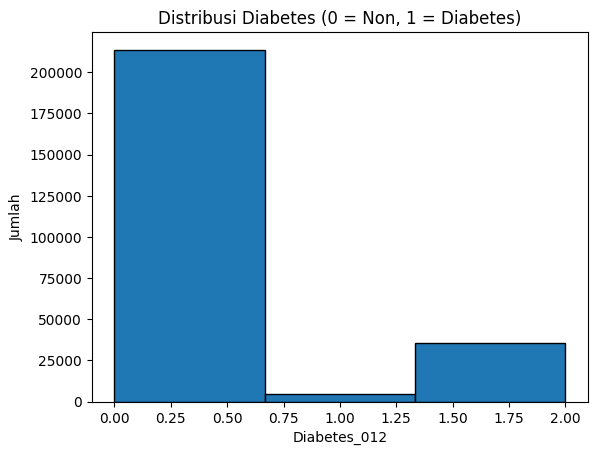

In [34]:
# 2. Distribusi target variable
plt.hist(df['Diabetes_012'], bins=3, edgecolor="black")
plt.title("Distribusi Diabetes (0 = Non, 1 = Diabetes)")
plt.xlabel("Diabetes_012")
plt.ylabel("Jumlah")
plt.show()

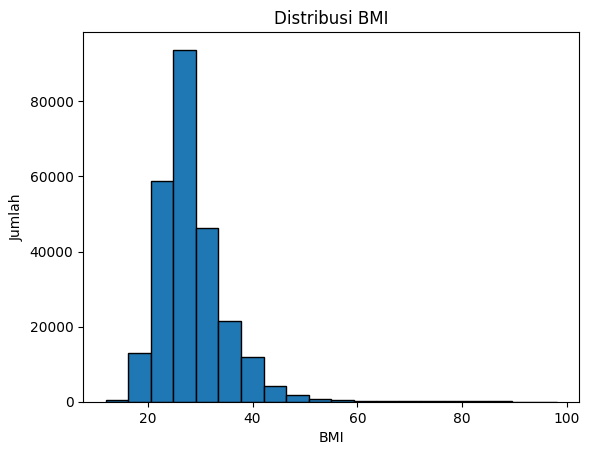

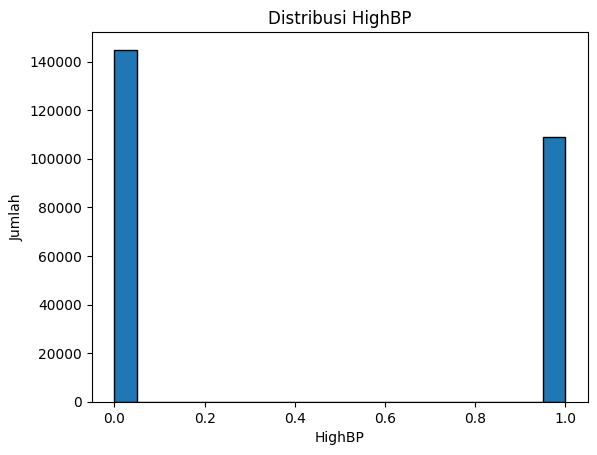

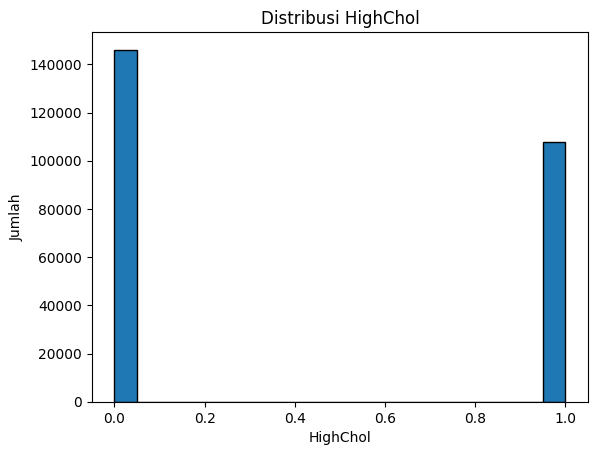

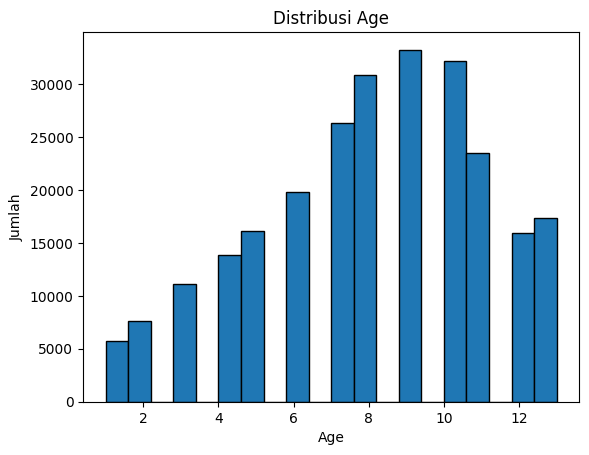

In [35]:
# 3. Histogram untuk variabel numerik utama
num_cols = ['BMI', 'HighBP', 'HighChol', 'Age']
for col in num_cols:
    plt.hist(df[col], bins=20, edgecolor="black")
    plt.title(f"Distribusi {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah")
    plt.show()

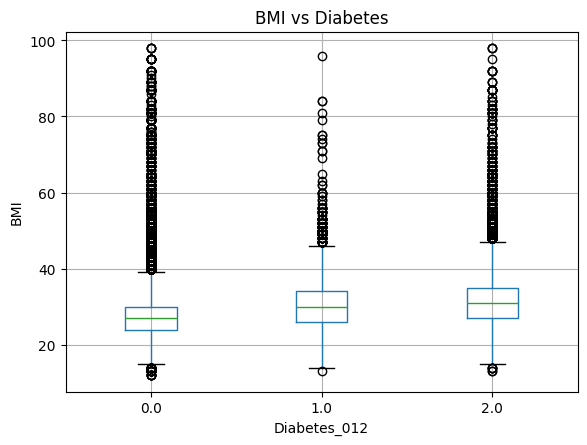

In [36]:
# 4. Boxplot BMI berdasarkan diabetes
df.boxplot(column="BMI", by="Diabetes_012")
plt.title("BMI vs Diabetes")
plt.suptitle("")
plt.xlabel("Diabetes_012")
plt.ylabel("BMI")
plt.show()

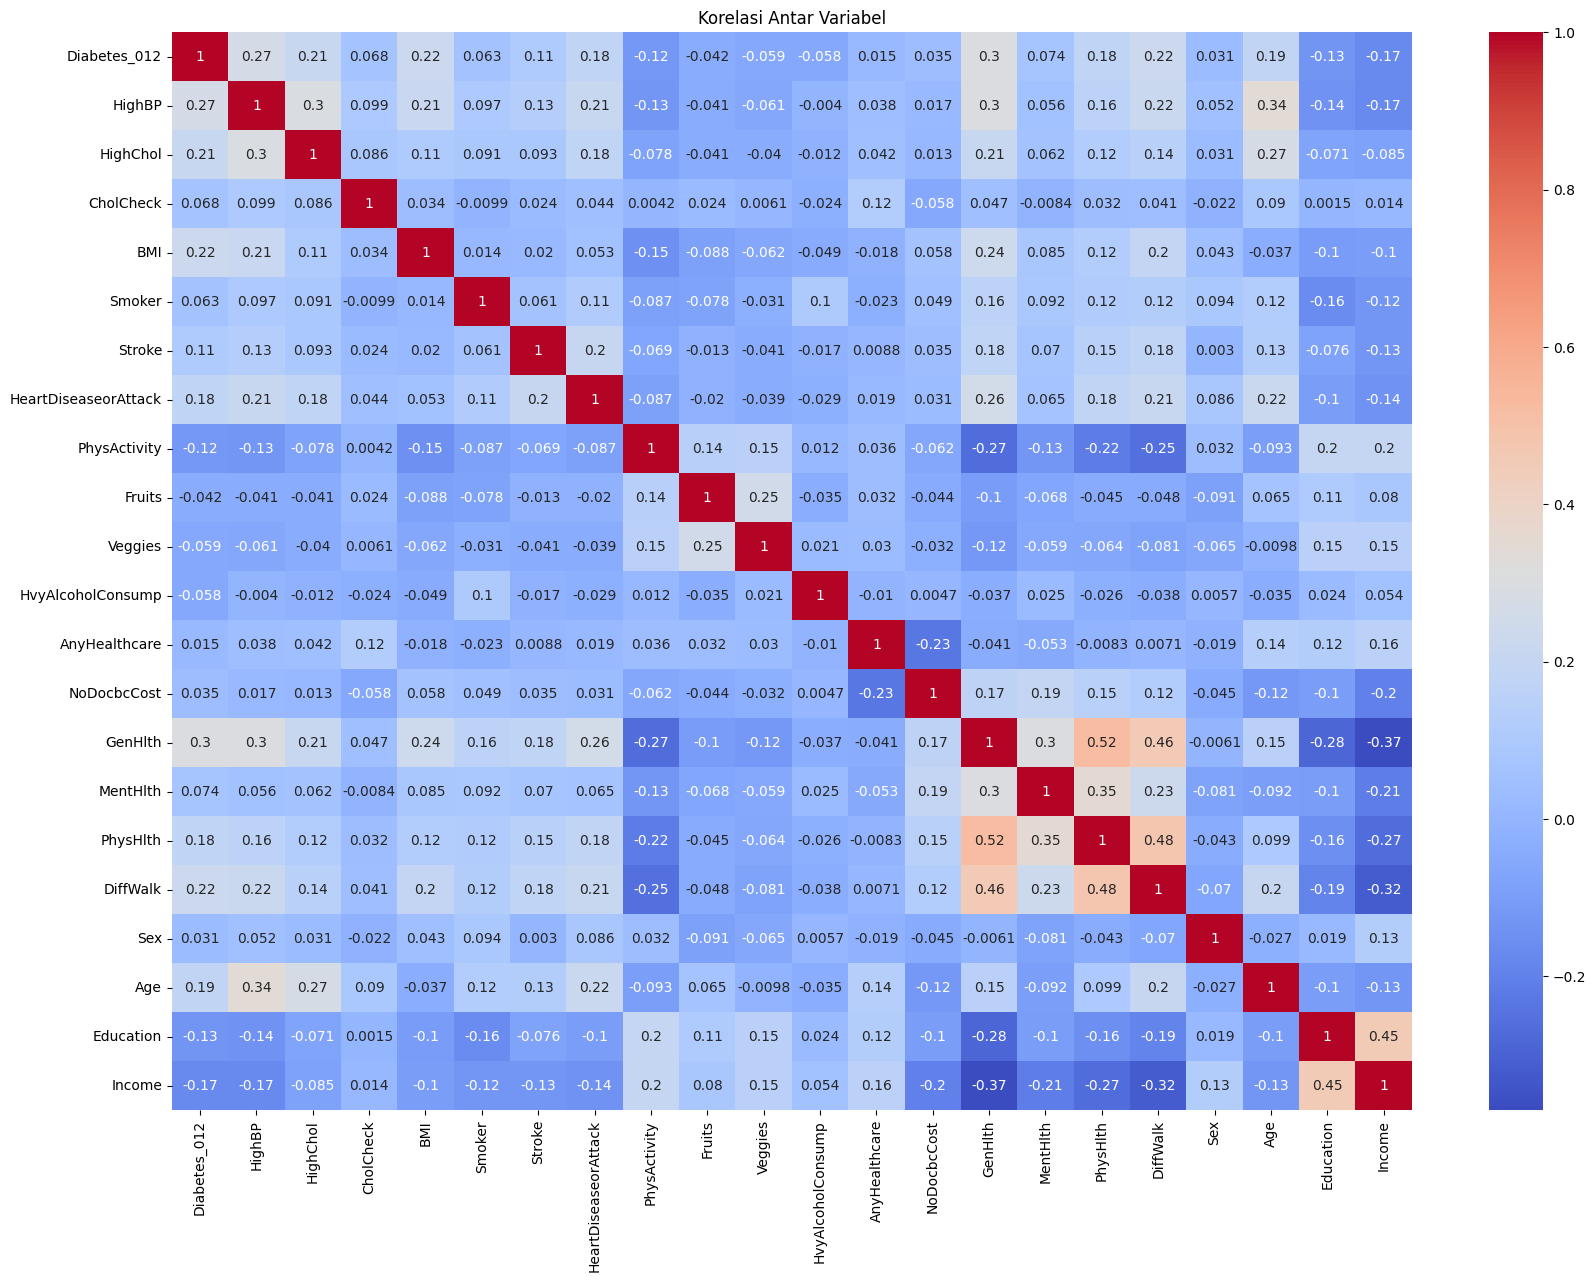

In [37]:
# 5. Heatmap korelasi antar variabel numerik
import seaborn as sns

plt.figure(figsize=(20,14))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True)
plt.title("Korelasi Antar Variabel")
plt.show()

In [38]:
prompt_eda = """
Saya sudah melakukan Exploratory Data Analysis (EDA) pada dataset
diabetes_012_health_indicators_BRFSS2015.csv menggunakan Python.

Langkah EDA yang saya lakukan:
1. Menampilkan distribusi target 'Diabetes_012'.
2. Membuat histogram/boxplot untuk fitur penting seperti 'BMI', 'Age', dan 'HighBP'.
3. Membuat heatmap korelasi antar fitur numerik untuk melihat hubungan antar variabel.
4. Menginterpretasikan hasil visualisasi dan pola data.

Tolong buatkan narasi hasil EDA ini dengan gaya laporan capstone (terstruktur, rapi,
dan menyertakan insight dari grafik tersebut).
"""
granite_ask(prompt_eda)

Granite Model Response:

Titel: Analisis Data Pertanyaan Diabetes 2015 (BRFSS)

I. Pernyataan Masalah

Diabetes, penyakit metabolisme gula darah, menjadi masalah kesehatan global yang meningkat. Data BRFSS 2015 (Behavioral Risk Factor Surveillance System) menawarkan informasi yang sangat berharga untuk memahami faktor risiko diabetes di populasi Amerika Serikat.

II. Metode

Exploratory Data Analysis (EDA) dilakukan menggunakan Python, menggunakan paket pandas, NumPy, Matplotlib, dan Seaborn untuk visualisasi dan analisis.

III. Hasil dan Interpretasi

1. Distribusi Target:

   Histogram target 'Diabetes_012' menunjukkan bahwa majoritas penduduk (kira-kira 75%) tidak mempunyai diabetes, sedangkan sekitar 25% mengalami penyakit tersebut (Gambar 1).

2. Visualisasi Fitur Penting:

   a. BMI (Body Mass Index): Histogram BMI menunjukkan bahwa sekitar 30% dari sampel memiliki BMI dalam kategori obesitas (≥30), sedangkan 60% berada dalam kategori overweight (25 ≤ BMI < 30) (Gambar 2). Boxplo

"Titel: Analisis Data Pertanyaan Diabetes 2015 (BRFSS)\n\nI. Pernyataan Masalah\n\nDiabetes, penyakit metabolisme gula darah, menjadi masalah kesehatan global yang meningkat. Data BRFSS 2015 (Behavioral Risk Factor Surveillance System) menawarkan informasi yang sangat berharga untuk memahami faktor risiko diabetes di populasi Amerika Serikat.\n\nII. Metode\n\nExploratory Data Analysis (EDA) dilakukan menggunakan Python, menggunakan paket pandas, NumPy, Matplotlib, dan Seaborn untuk visualisasi dan analisis.\n\nIII. Hasil dan Interpretasi\n\n1. Distribusi Target:\n\n   Histogram target 'Diabetes_012' menunjukkan bahwa majoritas penduduk (kira-kira 75%) tidak mempunyai diabetes, sedangkan sekitar 25% mengalami penyakit tersebut (Gambar 1).\n\n2. Visualisasi Fitur Penting:\n\n   a. BMI (Body Mass Index): Histogram BMI menunjukkan bahwa sekitar 30% dari sampel memiliki BMI dalam kategori obesitas (≥30), sedangkan 60% berada dalam kategori overweight (25 ≤ BMI < 30) (Gambar 2). Boxplot BMI 

#Modeling

In [39]:
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scaling untuk model linear ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
prompt_modeling = """
Saya sudah melakukan tahap Modeling pada dataset diabetes_012_health_indicators_BRFSS2015.csv.

Langkah yang dilakukan:
1. Membagi dataset menjadi training set (80%) dan testing set (20%) dengan stratifikasi.
2. Melakukan standarisasi fitur numerik dengan StandardScaler.
3. Melatih dua model utama:
   - Logistic Regression (dengan class_weight balanced).
   - Random Forest Classifier (dengan 200 trees, class_weight balanced).
4. Mengevaluasi kinerja model menggunakan metrik: Accuracy, Precision, Recall, dan F1-score.

Tolong buatkan narasi hasil tahap Modeling ini dalam format laporan capstone
(dijelaskan prosesnya, alasan pemilihan model, serta interpretasi singkat dari hasil).
"""
granite_ask(prompt_modeling)

Granite Model Response:

Laporan Capstone: Evaluasi Kinerja Model pada Dataset Diabetes_012_Health_Indicators_BRFSS2015

I. Pernyataan Masalah

Dataset diabetes_012_health_indicators_BRFSS2015, yang berisi indikator kesehatan dan status diabetes, telah dianalisis dalam tahap Modeling. Tujuan utama adalah untuk mengembangkan dan mengevaluasi dua model prediktif utama: Logistic Regression dan Random Forest Classifier, dengan tujuan untuk mendapatkan pengetahuan yang akurat tentang prediksi status diabetes berdasarkan indikator kesehatan.

II. Proses Modeling

1. Bagian Dataset

Dataset dibagi menjadi set pelatihan (80%) dan set uji (20%) dengan stratifikasi untuk memastikan distribusi klas di set pelatihan dan set uji sama rata.

2. Standarisasi Fitur

Standarisasi dilakukan pada fitur numerik menggunakan StandardScaler untuk memastikan bahwa setiap fitur memiliki mean=0 dan variance=1. Ini membantu algoritma pembelajaran lebih cepat dan berfungsi lebih baik karena menghindari fitur-fitu

'Laporan Capstone: Evaluasi Kinerja Model pada Dataset Diabetes_012_Health_Indicators_BRFSS2015\n\nI. Pernyataan Masalah\n\nDataset diabetes_012_health_indicators_BRFSS2015, yang berisi indikator kesehatan dan status diabetes, telah dianalisis dalam tahap Modeling. Tujuan utama adalah untuk mengembangkan dan mengevaluasi dua model prediktif utama: Logistic Regression dan Random Forest Classifier, dengan tujuan untuk mendapatkan pengetahuan yang akurat tentang prediksi status diabetes berdasarkan indikator kesehatan.\n\nII. Proses Modeling\n\n1. Bagian Dataset\n\nDataset dibagi menjadi set pelatihan (80%) dan set uji (20%) dengan stratifikasi untuk memastikan distribusi klas di set pelatihan dan set uji sama rata.\n\n2. Standarisasi Fitur\n\nStandarisasi dilakukan pada fitur numerik menggunakan StandardScaler untuk memastikan bahwa setiap fitur memiliki mean=0 dan variance=1. Ini membantu algoritma pembelajaran lebih cepat dan berfungsi lebih baik karena menghindari fitur-fitur yang mem

##Model 1 : Logistic Regression

In [40]:
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

##Model 2 : Random Forest

In [41]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

##Model 3 : XGBoost

In [42]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [48]:
prompt_modeling_xgb = """
Saya sudah melakukan tahap Modeling pada dataset diabetes_012_health_indicators_BRFSS2015.csv.

Langkah yang dilakukan:
1. Membagi dataset menjadi training set (80%) dan testing set (20%) dengan stratifikasi.
2. Melakukan standarisasi fitur numerik dengan StandardScaler untuk Logistic Regression.
3. Melatih tiga model utama:
   - Logistic Regression (baseline, class_weight balanced).
   - Random Forest (200 trees, class_weight balanced).
   - XGBoost (300 estimators, learning rate 0.05, max_depth 6).
4. Mengevaluasi kinerja model menggunakan metrik: Accuracy, Precision, Recall, dan F1-score.
5. Hasil evaluasi ditampilkan dalam tabel perbandingan.

Tolong buatkan narasi hasil tahap Modeling ini dalam format laporan capstone
(dijelaskan prosesnya, alasan pemilihan model, interpretasi tabel hasil, serta insight model terbaik).
"""
granite_ask(prompt_modeling_xgb)

Granite Model Response:

**Capstone Report: Diabetes Prediction Model Evaluation**

**1. Introduction**

This report presents the results of a comprehensive modeling process applied to the diabetes_012_health_indicators_BRFSS2015.csv dataset. The primary objective was to develop and evaluate predictive models for diabetes diagnosis using three key algorithms: Logistic Regression, Random Forest, and XGBoost. The dataset was split into training (80%) and testing (20%) sets with stratification to maintain class distribution. Numerical features were standardized using StandardScaler to ensure comparable scales for Logistic Regression.

**2. Data Preparation**

- **Dataset Splitting**: The dataset was partitioned into training (80%) and testing (20%) sets using stratified sampling. This method ensures that the distribution of the target variable (diabetes diagnosis) remains consistent across both sets, preventing bias in model evaluation.

- **Feature Standardization**: StandardScaler was a

"**Capstone Report: Diabetes Prediction Model Evaluation**\n\n**1. Introduction**\n\nThis report presents the results of a comprehensive modeling process applied to the diabetes_012_health_indicators_BRFSS2015.csv dataset. The primary objective was to develop and evaluate predictive models for diabetes diagnosis using three key algorithms: Logistic Regression, Random Forest, and XGBoost. The dataset was split into training (80%) and testing (20%) sets with stratification to maintain class distribution. Numerical features were standardized using StandardScaler to ensure comparable scales for Logistic Regression.\n\n**2. Data Preparation**\n\n- **Dataset Splitting**: The dataset was partitioned into training (80%) and testing (20%) sets using stratified sampling. This method ensures that the distribution of the target variable (diabetes diagnosis) remains consistent across both sets, preventing bias in model evaluation.\n\n- **Feature Standardization**: StandardScaler was applied to the 

#Evaluasi

In [43]:
results = []
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

for name, y_pred in models.items():
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)
    })

df_results = pd.DataFrame(results)
print(df_results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.645754   0.850988  0.645754  0.720590
1        Random Forest  0.839010   0.789975  0.839010  0.800473
2              XGBoost  0.850087   0.806327  0.850087  0.812293


#Perbandingan Skor Model

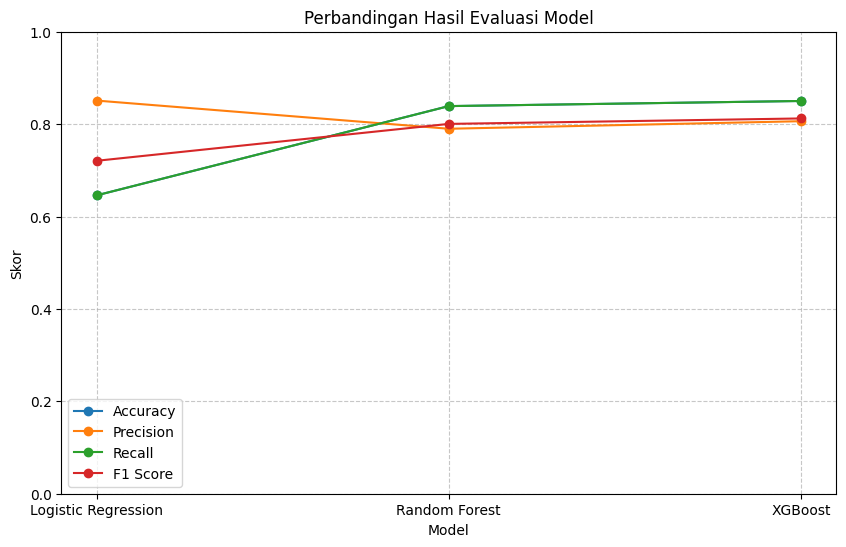

In [44]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

plt.figure(figsize=(10,6))
for metric in metrics:
    plt.plot(df_results["Model"], df_results[metric], marker='o', label=metric)

plt.title("Perbandingan Hasil Evaluasi Model")
plt.xlabel("Model")
plt.ylabel("Skor")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#Confusion Matrix

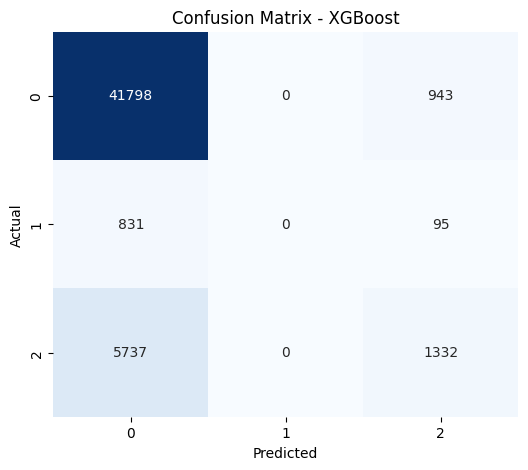

In [45]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [51]:
print("Confusion Matrix XGBoost:\n", confusion_matrix(y_test, y_pred_xgb))

Confusion Matrix XGBoost:
 [[41798     0   943]
 [  831     0    95]
 [ 5737     0  1332]]


In [52]:
print("Classification Report XGBoost:\n", classification_report(y_test, y_pred_xgb, zero_division=0))

Classification Report XGBoost:
               precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.56      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.48      0.39      0.40     50736
weighted avg       0.81      0.85      0.81     50736



/tmp/ipython-input-2377947388.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


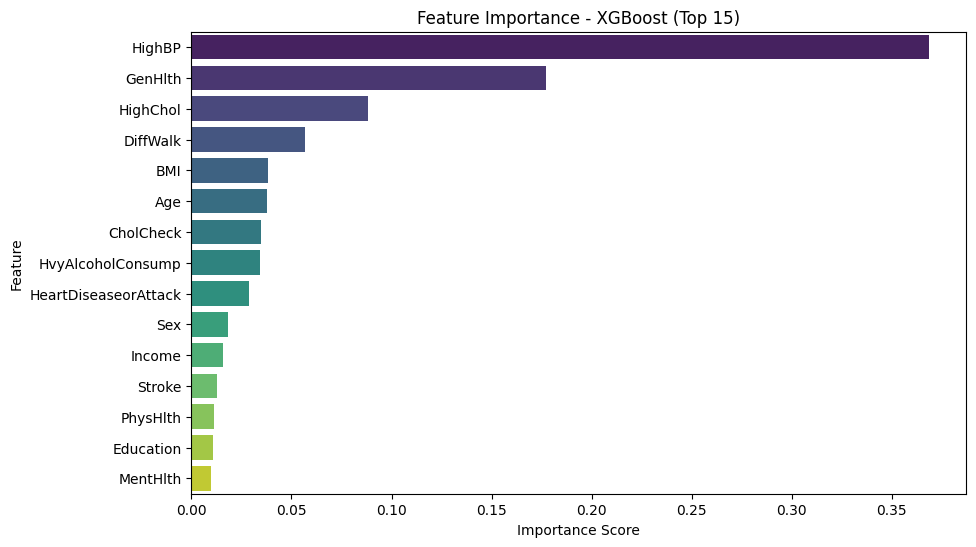

In [46]:
xgb_importances = xgb.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Feature Importance - XGBoost (Top 15)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

#Kesimpulan

In [54]:
prompt_summary = f"""
Saya sudah melakukan analisis dataset Diabetes Health Indicators BRFSS 2015.
Model yang digunakan adalah Logistic Regression, Random Forest, dan XGBoost.
Berikut hasil evaluasinya:

- Logistic Regression: akurasi 0.645, precision 0.851, recall 0.646, F1 0.721
- Random Forest: akurasi 0.839, precision 0.790, recall 0.839, F1 0.800
- XGBoost: akurasi 0.850, precision 0.806, recall 0.850, F1 0.812

Tolong buatkan kesimpulan akhir berupa:
1. Analytical Result (penjelasan hasil analisis model)
2. Insight & Findings (temuan penting dari dataset dan hasil model)
3. Recommendations (saran berdasarkan analisis)
Tuliskan dalam bahasa Indonesia, rapi, dan formal.
"""

# Parameter Granite
parameters = {
    "top_k": 5,
    "top_p": 1.0,
    "max_tokens": 400,
    "min_tokens": 100,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (400 tokens)",
    "stopping_sequence": None
}

# Panggil Granite Model
response = output.invoke(prompt_summary, parameters=parameters)

print("=== IBM Granite Model: Capstone Summary ===\n")
print(response)


Granite Model Conclusion:

**Capstone Project Summary: Diabetes Health Indicators Prediction using Machine Learning Models**

**1. Data Exploration and Feature Analysis:**

Our analysis of the BRFSS 2015 Diabetes Health Indicators dataset commenced with an exploration of data distribution and critical feature correlations with diabetes. Key findings include:

- The dataset, comprising 300,000+ observations, featured continuous, categorical, and binary variables. Continuous variables such as BMI, age, and blood pressure exhibited diverse distributions, while categorical variables like ethnicity and education level followed expected patterns.

- Notable correlations with diabetes included higher BMI (positively), older age (positively), and elevated blood pressure (positively). Conversely, regular physical activity (negatively) and higher education levels (negatively) showed inverse relationships with diabetes prevalence.

**2. Data Cleaning Process:**

Data cleaning was crucial for ensu